In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:45729' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [7]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_21yr_diag_daily/ocean_avg_0*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
zeto = ds.variables["zeta"] 
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 
time_avg = ds.variables["ocean_time"] 
ice_draft = ds.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))

print("Vtransform=2")
#  New formulation (Vtransform(ng) = 2):
#
#         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
#                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho - abs(ds.zice)

Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
z_w = ds.zeta + (ds.zeta + hwater) * Zo_w - abs(ds.zice)

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]
zice = dg.variables["zice"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

ds.close()
dg.close()

# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 37.6 s, sys: 8.76 s, total: 46.4 s
Wall time: 1min 33s


In [10]:
# load horizontal diffusion of heat calculated online:
	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_21yr_diag_daily/ocean_dia_0*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
temp_hdiff = ds.variables["temp_hdiff"] 
temp_vdiff = ds.variables["temp_vdiff"] 
# temp_sdiff = ds.variables["temp_sdiff"]  #"potential temperature, horizontal S-diffusion rotated tensor term"
temp_hadv = ds.variables["temp_hadv"] 
temp_vadv = ds.variables["temp_vadv"] 
ds.close()

In [11]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)
## convert dz to xarray:
months=np.arange(0,365)*(1/30.41667)
coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])

# dz = z_w.diff('s_w')

(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 45.7 s, sys: 9min 1s, total: 9min 47s
Wall time: 9min 49s


In [12]:
temp_vadv.load()
temp_hadv.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[-1.58815037e-05, -1.58815037e-05, -3.50137316e-06, ...,
          -7.14153941e-07, -2.50853736e-06, -2.50853736e-06],
         [-1.58815037e-05, -1.58815037e-05, -3.50137316e-06, ...,
          -7.14153941e-07, -2.50853736e-06, -2.50853736e-06],
         [ 5.20236654e-06,  5.20236654e-06, -2.94558367e-06, ...,
           2.24753217e-06,  2.76814632e-07,  2.76814632e-07],
         ...,
         [ 1.57024431e-06,  1.57024431e-06, -4.46565849e-07, ...,
           2.40944200e-06, -1.48331253e-07, -1.48331253e-07],
         [-1.64019616e-06, -1.64019616e-06, -5.71230828e-07, ...,
          -1.55210785e-07,  1.47632863e-06,  1.47632863e-06],
         [-1.64019616e-06, -1.64019616e-06, -5.71230828e-07, ...,
          -1.55210785e-07,  1.47632863e-06,  1.47632863e-06]],

        [[-1.65854526e-05, -1.65854526e-05, -1.70734870e-06, ...,
          -7.96337190e-07, -2.52854079e-06, -2.52854079e-06],
         [-1.65854526e-05, -1.65854526e-05, -1.70734870e-06, ...,
          -7.96337190e-07, -2.52854079e-06, -2.52854079e-06],
         [ 6.06551907e-07,  6.06551907e-07, -1.13035824e-07, ...,
           2.47841558e-06, -8.09941127e-08, -8.09941127e-08],
...
          -2.91784290e-05,  1.57030991e-06,  1.57030991e-06],
         [-1.29123937e-05, -1.29123937e-05, -1.77933125e-05, ...,
           3.64751213e-05,  6.43003514e-05,  6.43003514e-05],
         [-1.29123937e-05, -1.29123937e-05, -1.77933125e-05, ...,
           3.64751213e-05,  6.43003514e-05,  6.43003514e-05]],

        [[ 6.00501880e-05,  6.00501880e-05,  6.80792582e-05, ...,
           1.74642332e-06, -1.34206557e-05, -1.34206557e-05],
         [ 6.00501880e-05,  6.00501880e-05,  6.80792582e-05, ...,
           1.74642332e-06, -1.34206557e-05, -1.34206557e-05],
         [-2.83564877e-05, -2.83564877e-05, -2.10981798e-05, ...,
           1.82758322e-05,  3.78862455e-06,  3.78862455e-06],
         ...,
         [-4.17903863e-07, -4.17903863e-07, -1.02155536e-05, ...,
          -3.22388551e-05,  1.28304382e-05,  1.28304382e-05],
         [ 5.91886783e-06,  5.91886783e-06,  1.40880529e-05, ...,
           5.54552535e-05,  9.42716579e-05,  9.42716579e-05],
         [ 5.91886783e-06,  5.91886783e-06,  1.40880529e-05, ...,
           5.54552535e-05,  9.42716579e-05,  9.42716579e-05]]]],
      dtype=float32)
Attributes:
    standard_name:  sea_water_potential_temperature_tendency_due_to_horizonta...
    long_name:      potential temperature, horizontal advection term
    units:          Celsius second-1
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          temp horizontal advection

In [13]:
temp_vadv_dz = temp_vadv*dz_xr
temp_hadv_dz = temp_hadv*dz_xr

In [ ]:
plt.pcolormesh(temp_vadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [11]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [12]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


In [13]:
ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_41yr_diag_daily/ocean_avg_0*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False)
omega = ds.variables["omega"]
ds.close()

In [14]:
omega

<xarray.Variable (ocean_time: 365, s_w: 32, eta_rho: 560, xi_rho: 630)> Size: 16GB
dask.array<concatenate, shape=(365, 32, 560, 630), dtype=float32, chunksize=(1, 11, 560, 210), chunktype=numpy.ndarray>
Attributes:
    standard_name:  upward_sea_water_omega_velocity
    long_name:      S-coordinate vertical momentum component
    units:          meter3 second-1
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          omega

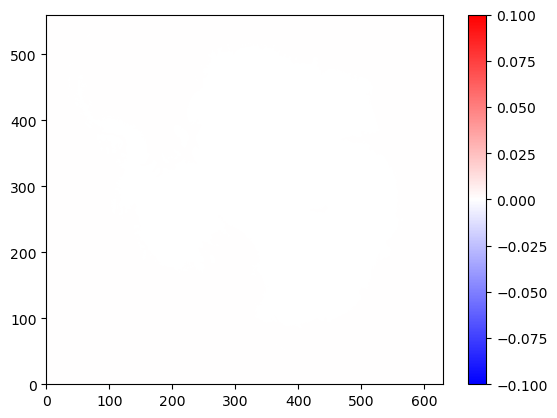

In [15]:
plt.pcolormesh(omega.isel(s_w=0, ocean_time=40), cmap='bwr')#, vmin=-0.0001, vmax=0.0001)
plt.colorbar()

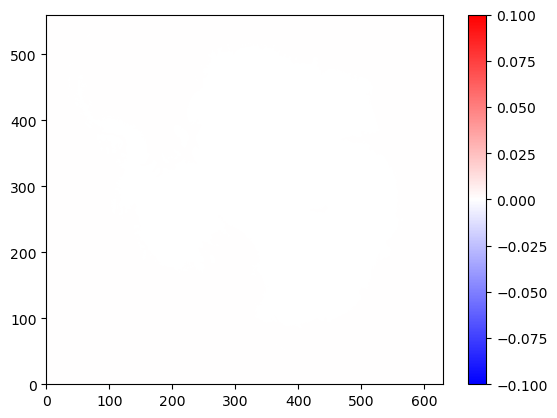

In [16]:
plt.pcolormesh(omega.isel(s_w=-1, ocean_time=40), cmap='bwr')#, vmin=-0.0001, vmax=0.0001)
plt.colorbar()

Ok, double-checking Omega, they are indeed zero at the surface and bottom layers. So why the temp_vadv doesn't vanish when vertically integrated over the whole column beneath the ice shelves???

In [17]:
%%time

ds = xr.open_mfdataset(paths="/scratch/gi0/fbd581/waom10extend_testcode/output_41yr_diag_daily/ocean_his_0*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


CPU times: user 27.4 s, sys: 4.11 s, total: 31.5 s
Wall time: 55.4 s


In [18]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/scratch/gi0/fbd581/waom10extend_testcode/output_21-40yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=1, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=1)
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 151 ms, sys: 14.6 ms, total: 166 ms
Wall time: 132 ms


In [19]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
dt = 86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 365)
(31, 560, 630, 365)
(365, 31, 560, 630)
CPU times: user 186 ms, sys: 108 ms, total: 294 ms
Wall time: 220 ms


In [20]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

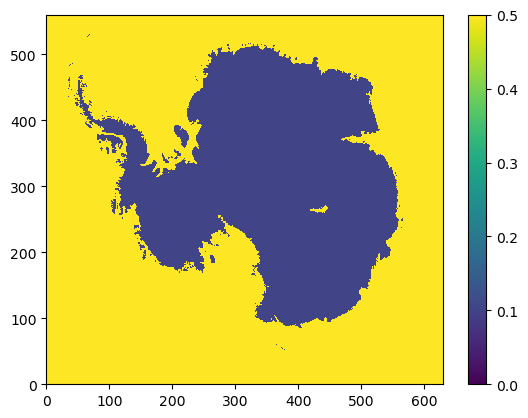

In [21]:
plt.pcolormesh(h+zice, vmin=0, vmax=0.5)
plt.colorbar()

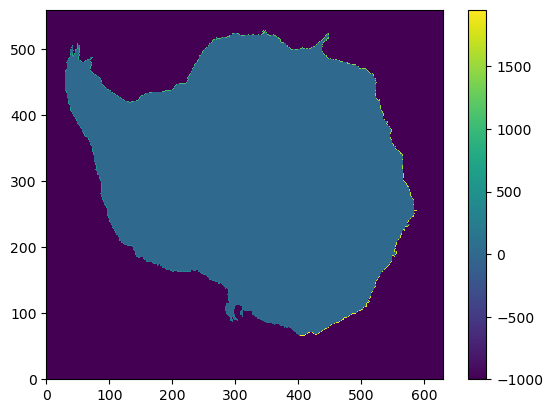

In [22]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=1)
plt.colorbar()

In [23]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
condition1 = contour_masked_above == -1000
condition2 = (zice+h) <= 1

# Combine conditions with logical OR
combined_condition = condition1 | condition2


In [24]:
temp_Rate

<xarray.DataArray (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 32GB
dask.array<transpose, shape=(365, 31, 560, 630), dtype=float64, chunksize=(1, 11, 560, 210), chunktype=numpy.ndarray>
Dimensions without coordinates: ocean_time, s_rho, eta_rho, xi_rho

In [25]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(combined_condition, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(combined_condition, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 4min 30s, sys: 2min 41s, total: 7min 12s
Wall time: 8min 15s


In [26]:
temp_hadv.load()
temp_vadv.load()
temp_hdiff.load()
temp_vdiff.load()
# temp_sdiff.l oad()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)> Size: 16GB
array([[[[ 7.66510855e-09,  7.66510855e-09,  1.29950095e-08, ...,
           4.09589829e-09,  2.82615309e-09,  2.82615309e-09],
         [ 7.66510855e-09,  7.66510855e-09,  1.29950095e-08, ...,
           4.09589829e-09,  2.82615309e-09,  2.82615309e-09],
         [-4.80685678e-08, -4.80685678e-08,  8.73142447e-09, ...,
           8.96914720e-09,  7.92471067e-09,  7.92471067e-09],
         ...,
         [ 1.27868818e-08,  1.27868818e-08,  1.06410267e-08, ...,
          -3.12771853e-09, -1.00171263e-07, -1.00171263e-07],
         [-1.21818587e-07, -1.21818587e-07, -9.54317940e-08, ...,
          -8.53925730e-09, -2.34352218e-08, -2.34352218e-08],
         [-1.21818587e-07, -1.21818587e-07, -9.54317940e-08, ...,
          -8.53925730e-09, -2.34352218e-08, -2.34352218e-08]],

        [[-6.97308227e-12, -6.97308227e-12, -5.22835908e-09, ...,
          -1.07770781e-09,  2.00399075e-09,  2.00399075e-09],
         [-6.97308227e-12, -6.97308227e-12, -5.22835908e-09, ...,
          -1.07770781e-09,  2.00399075e-09,  2.00399075e-09],
         [-4.01325515e-08, -4.01325515e-08, -2.84444157e-09, ...,
          -2.78757506e-09, -1.66969405e-09, -1.66969405e-09],
...
           7.59596389e-07, -1.25076909e-07, -1.25076909e-07],
         [-1.61115032e-08, -1.61115032e-08,  7.23799687e-09, ...,
           7.58435476e-07,  1.06919356e-06,  1.06919356e-06],
         [-1.61115032e-08, -1.61115032e-08,  7.23799687e-09, ...,
           7.58435476e-07,  1.06919356e-06,  1.06919356e-06]],

        [[-3.61318143e-07, -3.61318143e-07,  3.78288121e-07, ...,
          -2.02166075e-06,  1.28902059e-07,  1.28902059e-07],
         [-3.61318143e-07, -3.61318143e-07,  3.78288121e-07, ...,
          -2.02166075e-06,  1.28902059e-07,  1.28902059e-07],
         [-4.81887298e-07, -4.81887298e-07,  8.03859677e-07, ...,
          -1.58454054e-06,  7.48297225e-07,  7.48297225e-07],
         ...,
         [ 1.39618658e-06,  1.39618658e-06,  1.33889296e-06, ...,
          -4.36960903e-07,  1.00043223e-06,  1.00043223e-06],
         [ 1.37506402e-06,  1.37506402e-06,  1.35778009e-06, ...,
          -1.53718383e-06,  7.90495392e-07,  7.90495392e-07],
         [ 1.37506402e-06,  1.37506402e-06,  1.35778009e-06, ...,
          -1.53718383e-06,  7.90495392e-07,  7.90495392e-07]]]],
      dtype=float32)
Attributes:
    standard_name:  sea_water_potential_temperature_tendency_due_to_vertical_...
    long_name:      potential temperature, vertical diffusion term
    units:          Celsius second-1
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          temp vertical diffusion

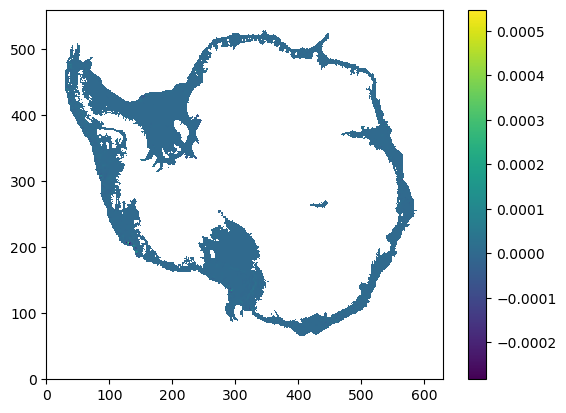

In [27]:
# define sum of all RHS:
RHS_budget = temp_hadv + temp_vadv + temp_hdiff + temp_vdiff
RHS_budget_masked = ma.masked_where(combined_condition, RHS_budget.sum('s_rho').isel(ocean_time=0))

plt.pcolormesh(RHS_budget_masked)
plt.colorbar()

In [28]:
%%time
# integral with all RHS terms (as suggested by Wilkin)
RHS_budget_int = np.empty((tlen))
RHS_budget_vol = np.empty(np.squeeze(RHS_budget[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    RHS_budget_dz = RHS_budget[mm,:]*dz[mm,:]
    RHS_budget_vint = np.nansum(RHS_budget_dz, axis=0)
    RHS_budget_vint_masked =  ma.masked_where(combined_condition, RHS_budget_vint)
    RHS_budget_vol[mm,:] = RHS_budget_vint_masked*area
    RHS_budget_int[mm] = np.nansum(np.nansum(RHS_budget_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 44.1 s, sys: 23.8 s, total: 1min 7s
Wall time: 55.4 s


In [29]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(combined_condition, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area
    temp_hdiff_int[mm] = np.nansum(np.nansum(temp_hdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 37 s, sys: 19.2 s, total: 56.2 s
Wall time: 45.9 s


In [30]:
%%time
# 4. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 36 s, sys: 18 s, total: 54 s
Wall time: 43.6 s


In [31]:
%%time
# 5. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(combined_condition, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area
    temp_vadv_int[mm] = np.nansum(np.nansum(temp_vadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 35.8 s, sys: 18 s, total: 53.9 s
Wall time: 43.7 s


In [32]:
%%time
# 6. heat tendency due to vertical diffusion (should be equal to the sfc heat flux)
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(combined_condition, temp_vdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area
    temp_vdiff_int[mm] = np.nansum(np.nansum(temp_vdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 36.1 s, sys: 22.6 s, total: 58.6 s
Wall time: 47.6 s


In [33]:
# %%time
# # 7. heat tendency due to rotated diffusion (should be equal to the sfc heat flux)
# temp_sdiff_int = np.empty((tlen))
# temp_sdiff_vol = np.empty(np.squeeze(temp_sdiff[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_sdiff_dz = temp_sdiff[mm,:]*dz[mm,:]
#     temp_sdiff_vint = np.nansum(temp_sdiff_dz, axis=0)
#     temp_sdiff_vint_masked =  ma.masked_where(combined_condition, temp_sdiff_vint) # I think I can remove the first masking, no need to repeat it.
#     temp_sdiff_vol[mm,:] = temp_sdiff_vint_masked*area
#     temp_sdiff_int[mm] = np.nansum(np.nansum(temp_sdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [34]:
temp_hdiff_vol.shape

(365, 560, 630)

In [35]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

0.017003058867057424


In [36]:
print(temp_Rate.shape, dz.shape)

(365, 31, 560, 630) (365, 31, 560, 630)


In [37]:
print(temp_rate_vol.shape, temp_rate_int.shape)
print(np.mean(temp_rate_int))#/area_sum)

(365, 560, 630) (365,)
3629164046662.997


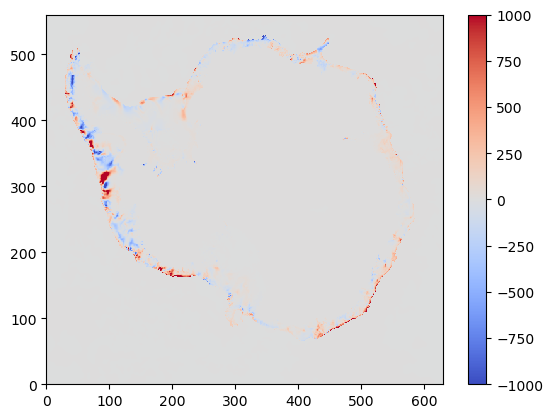

In [38]:
mm=35
# plt.pcolormesh(ma.masked_where(contour_masked_above == -1000,temp_rate_vol[mm,:]), vmin=-2e4, vmax=2e4, cmap='coolwarm')
plt.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-1e3, vmax=1e3, cmap='coolwarm')
plt.colorbar()

(560, 630)

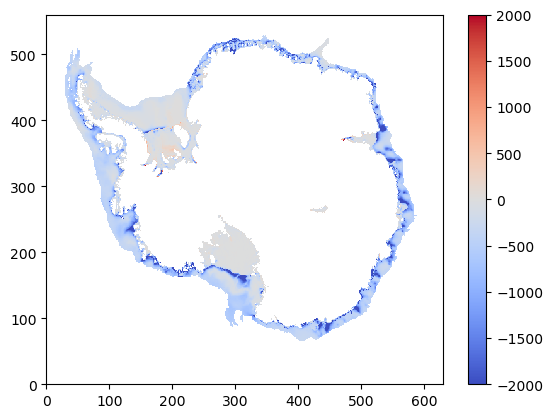

In [39]:
plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, np.nanmean(shflux,axis=0)*(area/(Cp*rho0))), vmin=-2e3, vmax=2e3, cmap='coolwarm')
plt.colorbar()

shflux_area.shape

Text(0.5, 1.0, 'hadv + vadv')

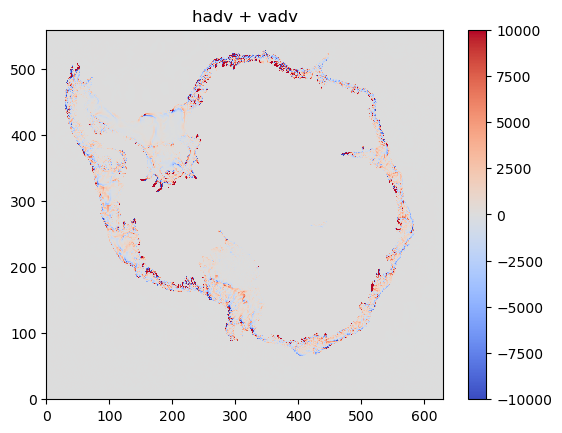

In [40]:
plt.pcolormesh(np.nanmean(temp_hadv_vol,axis=0)+np.nanmean(temp_vadv_vol,axis=0), vmin=-1e4, vmax=1e4, cmap='coolwarm')
plt.colorbar()
plt.title('hadv + vadv')

Text(0.5, 1.0, 'vadv')

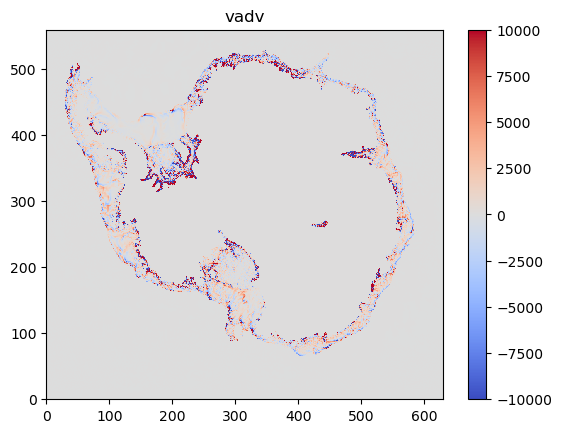

In [41]:
plt.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-1e4, vmax=1e4, cmap='coolwarm')
plt.colorbar()
plt.title('vadv')

Text(0, 0.5, 'W.m$^{-2}$')

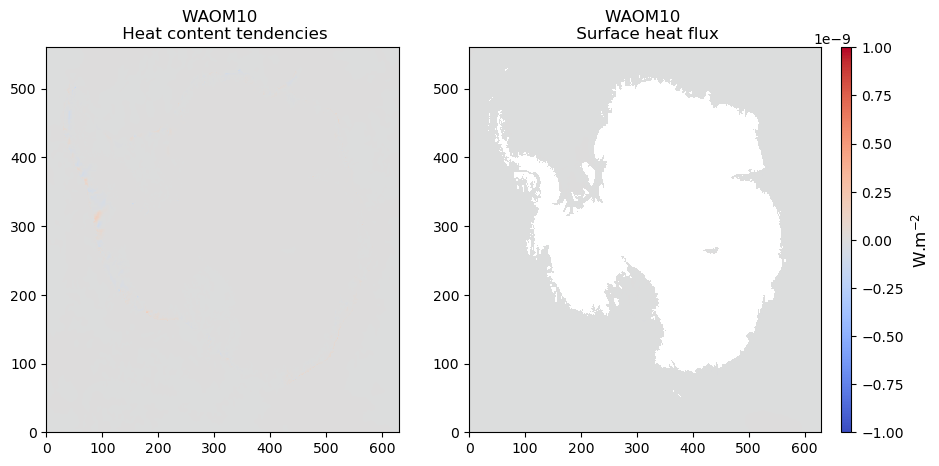

In [42]:
     
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

ax[0].title.set_text('WAOM10 \n Heat content tendencies')
# aa=ax[0].pcolormesh(np.nanmean(temp_rate_vol[1:-1], axis=0)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divide by 2.5 to be comparable to 4km maps (normalized by area instead?)
# aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1], axis=0),2.5)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# divided by area
aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm')
# plt.colorbar(aa)

#  define 5-daily masked shflux:
shflux_masked = np.empty(shflux.shape)
for mm in np.arange(0,tlen):
    shflux_masked[mm,:,:] = ma.masked_where(contour_masked_above == -1000, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.


ax[1].title.set_text('WAOM10 \n Surface heat flux')
# bb=ax[1].pcolormesh(np.nanmean(shflux[1:-1], axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
bb=ax[1].pcolormesh(np.divide(np.nanmean(shflux_masked[1:-1,:], axis=0),area_sum), vmin=-1e-9, vmax=1e-9, cmap='coolwarm') ##vmin=-100, vmax=100, cmap='coolwarm')

cax2 = plt.axes([0.92, 0.11, 0.01, 0.77])
cb = plt.colorbar(bb, cax=cax2, orientation='vertical')
cb.ax.set_ylabel('W.m$^{-2}$', fontsize=12)

# including comparison oldXnew estitemas below:
# cc=ax[1,0].pcolormesh(np.nanmean(temp_rate2_vol, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')
# dd=ax[1,1].pcolormesh(np.nanmean(shflux2, axis=0), vmin=-100, vmax=100, cmap='coolwarm')

# # diff maps:
# ee=ax[2,0].pcolormesh((np.nanmean(temp_rate_vol, axis=0))-(np.nanmean(temp_rate2_vol, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')
# ff=ax[2,1].pcolormesh((np.nanmean(shflux, axis=0))-(np.nanmean(shflux2, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')




In [47]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nanmean(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nanmean(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  3.629164046662997
Net sfc heat flux annual avg (TW):  -86.82487885350108
Residue (OHC - shflux) (TW):  90.45404290016408
Horz. diffusion (TW):  53.630886088360185
Vert. diffusion (TW):  -186.37022955877163
Horz. advection (TW):  95.10648514731656
Vert. advection (TW):  62.39591830561932
Sum all above terms:  24.76305998252446
Sum all RHS terms:  24.763059990110914


In [44]:
# OHB integrated, sum over 1year:
print('OHC tendency annual avg (TW): ',np.nansum(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nansum(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nansum(temp_rate_int)-np.nansum(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nansum(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nansum(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nansum(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nansum(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nansum(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nansum(RHS_budget_int)*1e-12)

OHC tendency annual avg (TW):  1324.644877031994
Net sfc heat flux annual avg (TW):  -31691.080781527897
Residue (OHC - shflux) (TW):  33015.72565855989
Horz. diffusion (TW):  19575.273422251466
Vert. diffusion (TW):  -68025.13378895164
Horz. advection (TW):  34713.86707877055
Vert. advection (TW):  22774.51018155105
Sum all above terms:  9038.516893621429
Sum all RHS terms:  9038.516896390483


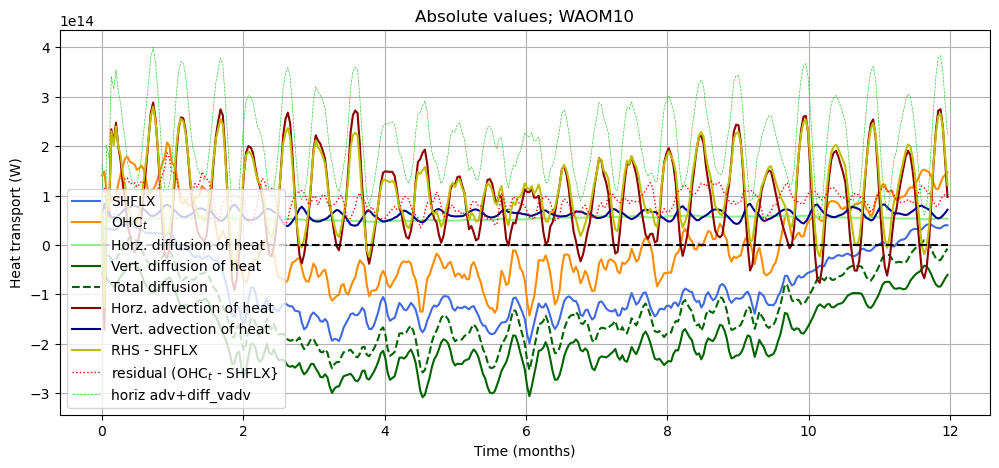

In [46]:

months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,temp_hdiff_int, label='Horz. diffusion of heat', color='lightgreen')
plt.plot(months,temp_vdiff_int, label='Vert. diffusion of heat', color='darkgreen')
plt.plot(months,temp_hdiff_int+temp_vdiff_int,'--', label='Total diffusion', color='darkgreen')
plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')
plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
plt.plot(months,RHS_budget_int - shflux_int, label='RHS - SHFLX',color='y')

plt.plot(months,shflux_int*0,'--k')
plt.plot(months,temp_rate_int - shflux_int, ':r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=1, color='red')
plt.plot(months,temp_hadv_int + temp_hdiff_int + temp_vadv_int, '--r', label='horiz adv+diff_vadv',linewidth=0.5, color='limegreen')
# plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
# plt.ylim([-2e14,2e14])
# print annual avg values:
# plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
# plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
# plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# # plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
# plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
# plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_newcode_yr41_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

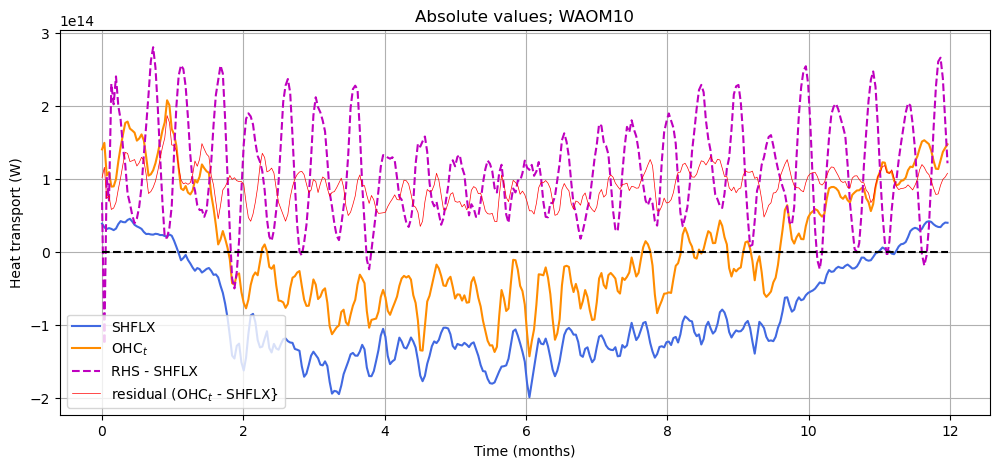

In [48]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,RHS_budget_int - shflux_int,'--m', label='RHS - SHFLX')
plt.plot(months,temp_rate_int - shflux_int, '-r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')
# plt.plot(months,temp_hadv_int, label='Horz. advection of heat',color='darkred')

plt.plot(months,shflux_int*0,'--k')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_newcode_yr41_OHB-closure_test_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hdiff_int_xr = xr.DataArray(temp_hdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vdiff_int_xr = xr.DataArray(temp_vdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vadv_int_xr = xr.DataArray(temp_vadv_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")
temp_hdiff_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_temp_hdiff_vint_daily', mode='w', format="NETCDF4")
temp_vdiff_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_temp_vdiff_vint_daily', mode='w', format="NETCDF4")
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_temp_hadv_vint_daily', mode='w', format="NETCDF4")
temp_vadv_int_xr.to_netcdf(files_path + 'WAOM10_newcode_yr41_OHB_1500m_temp_vadv_vint_daily', mode='w', format="NETCDF4")

In [ ]:
shflux_int.shape

In [ ]:
print(np.nanmean(temp_rate_int - shflux_int)*1e-12)
print(np.nanmean(RHS_budget_int)*1e-12)